# Antimicrobial Resistance (AMR) Data Analysis

## Introduction
This notebook focuses on the analysis of Antimicrobial Resistance (AMR) data. The primary objective is to process raw AMR data, transform it into a usable format, and explore patterns related to antibiotic resistance. The dataset includes information on the origin of samples, bacterial types, and their resistance profiles to various antibiotics.

## Overall Goal
The overarching goal of this analysis is to gain insights into antimicrobial resistance patterns and potentially build a predictive model for some chosen bacteria resistance based on the characteristics of bacterial isolates.

## Section 1: Data Loading, Cleaning, and Preprocessing

### Goal
The goal of this section is to load the raw antimicrobial resistance (AMR) data from an Excel file, clean it by handling special characters and inconsistent formatting, and transform it into a structured DataFrame suitable for further analysis. This involves:
- Loading data from `AMR.xlsx`.
- Restructuring the data into a row-per-sample format.
- Standardizing column names and values.
- Merging relevant information and setting 'Sample_ID' as the index.
- Saving the cleaned data to `AMR_merged_all_samples_ordered.xlsx` for subsequent use.

In [23]:
import pandas as pd

# Load Excel file
file_path = "AMR.xlsx"
df_raw = pd.read_excel(file_path, sheet_name=0, header=None)

# Split into chunks of 3 rows (but only keep first 2 rows from each)
chunks = [df_raw.iloc[i:i+2].reset_index(drop=True) for i in range(0, len(df_raw), 3)]

# Function to make column names unique
def make_unique(columns):
    seen = {}
    new_cols = []
    for col in columns:
        col = str(col).strip()
        if col not in seen:
            seen[col] = 0
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}.{seen[col]}")
    return new_cols

df_list = []

for chunk in chunks:
    if chunk.shape[0] < 2:
        continue  # Skip incomplete chunks with less than 2 rows

    # Label the first row
    chunk.at[0, 0] = "Origin"
    chunk.at[0, 1] = "Bacteria"
    chunk.at[0, 2] = "Sample_ID"

    # Ensure unique and valid column headers
    header = make_unique(chunk.iloc[0])

    # Create DataFrame from the second row using fixed headers
    try:
        df = pd.DataFrame([chunk.iloc[1].values], columns=header)
        df_list.append(df)
    except Exception as e:
        print(f"Skipping chunk due to error: {e}")

# Concatenate all valid DataFrames
merged_df = pd.concat(df_list, ignore_index=True, sort=True)

# Clean special characters (e.g., "*R" → "R")
merged_df = merged_df.applymap(lambda x: str(x).replace('*', '').strip() if isinstance(x, str) else x)

# Set 'Sample_ID' as index
merged_df.set_index("Sample_ID", inplace=True)

# Reorder columns: Origin → Bacteria → (other antibiotic columns)
cols = merged_df.columns.tolist()
core = ["Origin", "Bacteria"]
rest = [col for col in cols if col not in core]
ordered_columns = core + rest
merged_df = merged_df[ordered_columns]

# Save final result
output_path = "AMR_merged_all_samples_ordered.xlsx"
merged_df.to_excel(output_path)

print(f"Merged AMR data with Sample_ID as index saved to: {output_path}")


C:\Users\virgi\AppData\Local\Temp\ipykernel_14020\1906032488.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_df = merged_df.applymap(lambda x: str(x).replace('*', '').strip() if isinstance(x, str) else x)


Merged AMR data with Sample_ID as index saved to: AMR_merged_all_samples_ordered.xlsx


### 🔬 1. Resistance Pattern Analysis by Bacterial Species

**🎯 Goal:**  
Identify which bacterial species show the highest resistance across different antibiotics.

**🔍 How:**  
- Group the dataset by **bacterial species name**.
- For each antibiotic, calculate the **resistance frequency** (i.e., how often the result is "R").
- Normalize the values to get percentages of resistance per species per antibiotic.

**📊 Visualization:**  
A **heatmap** is used to show the percentage of resistance (`%R`) for each bacterial species across antibiotics.
- Darker colors indicate higher resistance levels.
- Lighter colors indicate lower resistance levels or susceptibility.


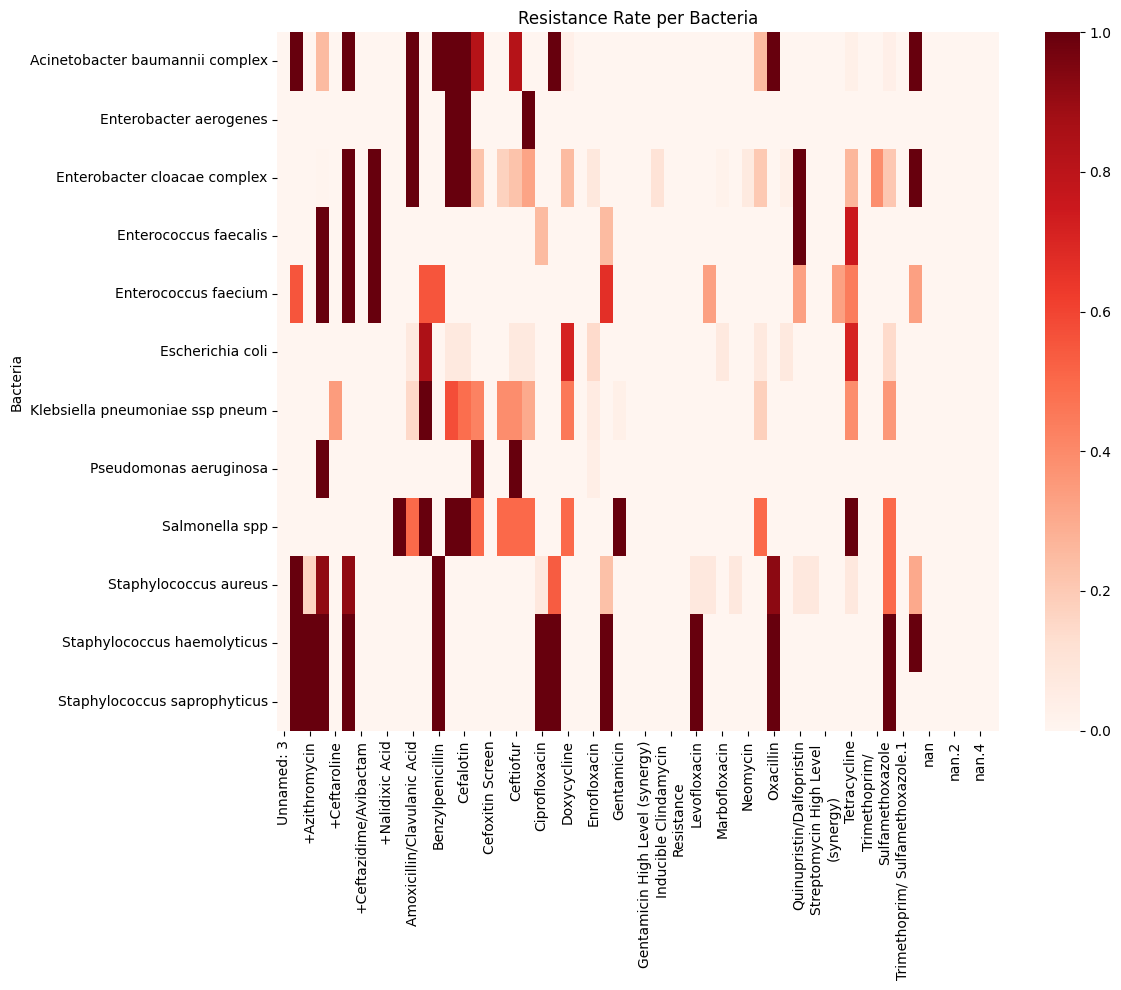

In [24]:
df = pd.read_excel('AMR_merged_all_samples_ordered.xlsx')

import seaborn as sns
import matplotlib.pyplot as plt

# Select resistance columns
resistance_cols = df.columns[3:]

# Compute resistance rates per bacteria
pattern = df.groupby('Bacteria')[resistance_cols].apply(lambda x: (x == 'R').sum() / x.notna().sum())

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pattern.fillna(0), cmap="Reds")
plt.title("Resistance Rate per Bacteria")
plt.tight_layout()
plt.show()

### 🌍 2. Geographical/Source-Based Resistance Profiling

**🎯 Goal:**  
Compare resistance profiles of the same bacterial species across different origins (e.g., hospital, lake, fish, etc.).

**🔍 How:**  
- Filter the data by a target bacterial species.
- Group the data by **Origin** and calculate resistance frequencies for each antibiotic.
- Focus on comparing how the same species behaves differently across sample sources.

**📊 Visualization:**  
Use a **clustered bar chart** or **grouped heatmap** to display resistance patterns per origin.  
This helps stakeholders identify hotspots of high resistance and source-specific concerns.


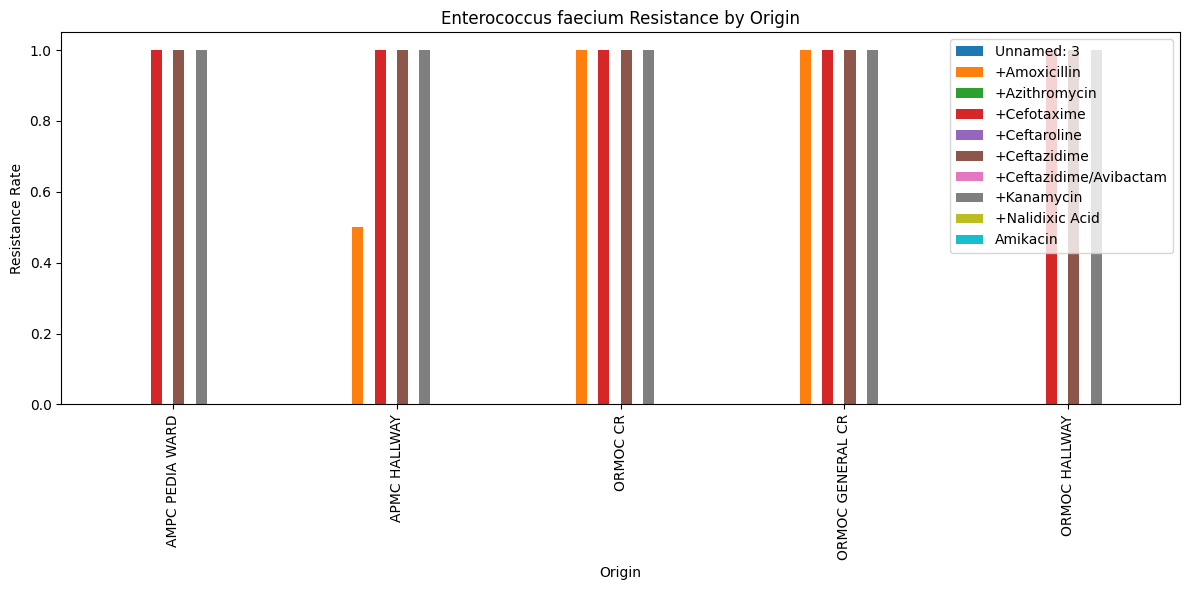

In [25]:
source_profile = df.groupby(['Origin', 'Bacteria'])[resistance_cols].apply(lambda x: (x == 'R').mean())

# Visualize a few bacteria from different origins
subset = source_profile.reset_index().query("Bacteria == 'Enterococcus faecium'")
subset = subset.set_index('Origin')[resistance_cols[:10]]  # Plot first 10 antibiotics

subset.plot(kind='bar', figsize=(12, 6), title="Enterococcus faecium Resistance by Origin")
plt.ylabel("Resistance Rate")
plt.tight_layout()
plt.show()


### 🧬 3. Multidrug Resistance (MDR) Analysis

**🎯 Goal:**  
Determine the proportion of isolates that are resistant to multiple antibiotics (multidrug resistant).

**🔍 How:**  
- Count the number of antibiotics each isolate is resistant to.
- Define an isolate as MDR if it is resistant to **three or more** antibiotics.
- Label each isolate as MDR or non-MDR.

**📊 Visualization:**  
- A **histogram** showing the distribution of resistance counts across isolates.  
- A **pie chart** showing the proportion of MDR vs. non-MDR isolates.  
This informs public health officials of the potential severity of resistance spread.


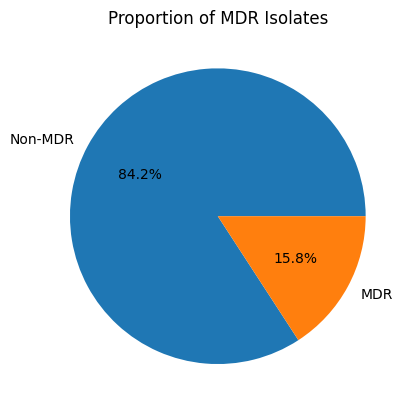

In [18]:
# Count how many antibiotics each isolate is resistant to
df['resistant_count'] = (df[resistance_cols] == 'R').sum(axis=1)
df['MDR'] = df['resistant_count'] >= 3

# Plot
df['MDR'].value_counts().plot(kind='pie', labels=['Non-MDR', 'MDR'], autopct='%1.1f%%')
plt.title("Proportion of MDR Isolates")
plt.ylabel('')
plt.show()


### 🤝 4. Co-resistance Network Analysis

**🎯 Goal:**  
Explore patterns of co-resistance — when resistance to one antibiotic is likely associated with resistance to another.

**🔍 How:**  
- Convert resistance values into binary (1 = Resistant, 0 = Otherwise).
- Calculate a **correlation matrix** between all antibiotics using this binary data.
- High correlation values suggest strong co-resistance.

**📊 Visualization:**  
- A **heatmap** showing correlations between antibiotics.  
- (Optionally) a **network graph** where nodes are antibiotics and edges represent co-resistance strength.  
This reveals clusters of antibiotics that may fail together if resistance emerges.


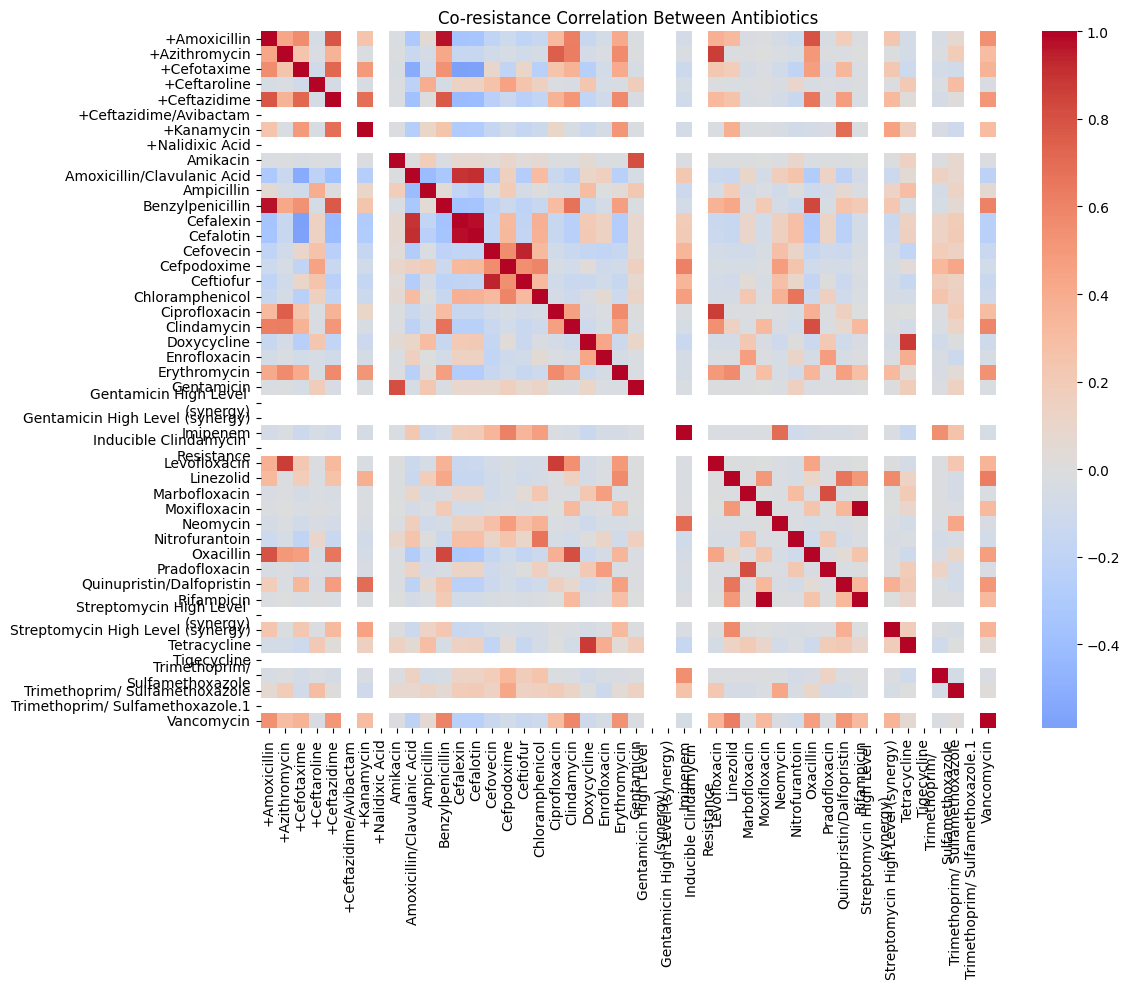

In [19]:
import numpy as np

# Binary encoding: R=1, others=0
binary_df = (df[resistance_cols] == 'R').astype(int)

# Correlation matrix
corr_matrix = binary_df.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Co-resistance Correlation Between Antibiotics")
plt.tight_layout()
plt.show()


### 📈 5. Trend Analysis of Resistance by Antibiotic

**🎯 Goal:**  
Determine whether certain antibiotics are becoming less effective based on origin or over time.

**🔍 How:**  
- Group the data by **Origin** or **Time** (if available).
- For each group, calculate the resistance rate per antibiotic.
- Compare how resistance rates vary by group.

**📊 Visualization:**  
Use **line plots** or **stacked bar charts** to show trends in antibiotic resistance.  
This helps identify geographic trends or worsening resistance over time.


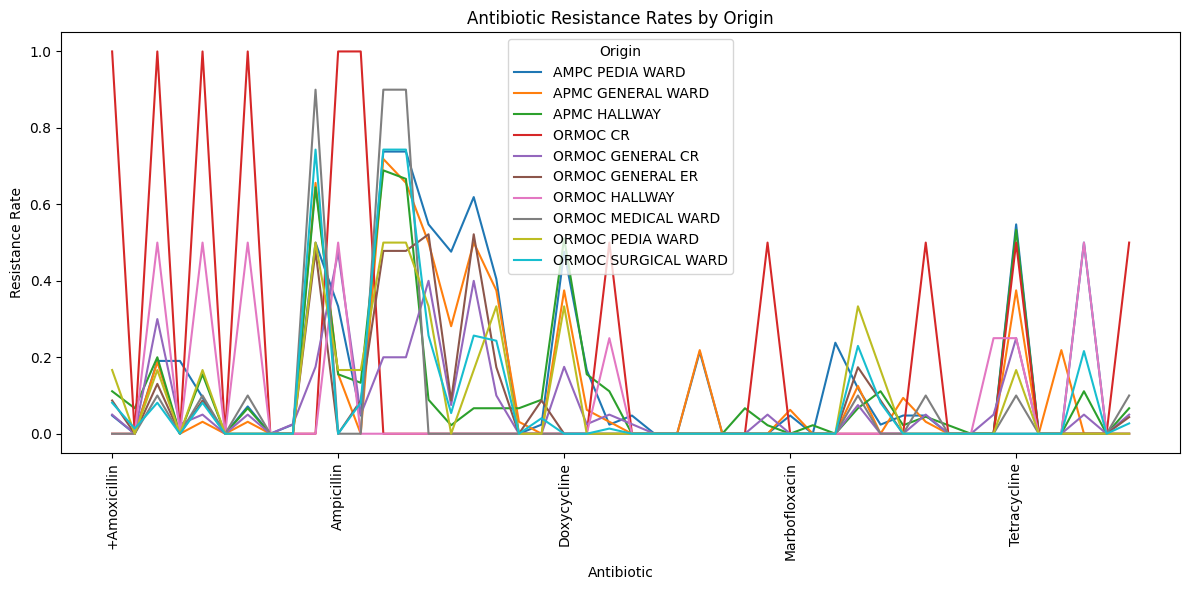

In [20]:
origin_trend = df.groupby('Origin')[resistance_cols].apply(lambda x: (x == 'R').mean())

origin_trend.T.plot(kind='line', figsize=(12, 6))
plt.title("Antibiotic Resistance Rates by Origin")
plt.ylabel("Resistance Rate")
plt.xlabel("Antibiotic")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 📊 7. Principal Component Analysis (PCA)

**🎯 Goal:**  
Visualize and reduce the dimensionality of resistance data to reveal patterns.

**🔍 How:**  
- Encode resistance results as binary: R = 1, others = 0.
- Perform **Principal Component Analysis (PCA)** on the resistance data.
- Color-code points by bacteria or origin to observe clustering.

**📊 Visualization:**  
A **2D scatter plot** of the first two principal components (PC1 and PC2), grouped by bacteria or source.  
Helps detect groups of bacteria or origins with similar resistance profiles.


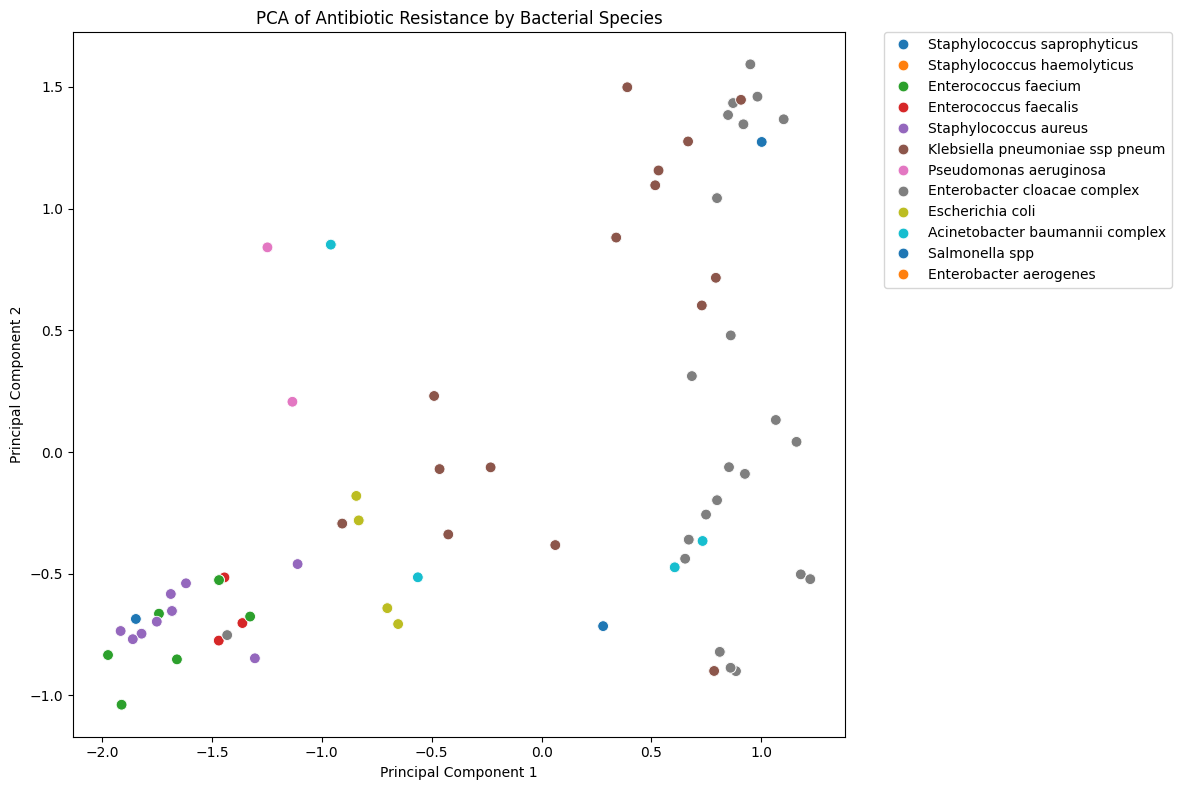

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare binary matrix
X = binary_df.fillna(0)

# PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)
df['PC1'], df['PC2'] = components[:, 0], components[:, 1]

# Plot with legend
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df, x='PC1', y='PC2', hue='Bacteria', palette='tab10', legend='full', s=60)

# Move legend outside plot if too many classes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("PCA of Antibiotic Resistance by Bacterial Species")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


### 🔗 8. Predictive Modeling of Resistance

**🎯 Goal:**  
Build a machine learning model to predict resistance (e.g., to Vancomycin) based on bacterial species and sample origin.

**🔍 How:**  
- Set up a binary classification target (e.g., R = 1, others = 0 for Vancomycin).
- Use **Origin** and **Bacteria** as predictors.
- Encode categorical features using Label Encoding.
- Train a **Random Forest** or other classification model.
- Evaluate using accuracy, precision, recall, and F1 score.

**📊 Visualization:**  
- A **classification report** and **confusion matrix** to assess model performance.  
- A **feature importance chart** to show which inputs most influence the prediction.

This model supports early-warning systems and decision support tools in AMR surveillance.


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Target and features
target = (df['Vancomycin'] == 'R').astype(int)
features = df[['Origin', 'Bacteria']].copy()

# Encode categorical features
le_origin = LabelEncoder()
le_bact = LabelEncoder()
features['Origin'] = le_origin.fit_transform(features['Origin'].astype(str))
features['Bacteria'] = le_bact.fit_transform(features['Bacteria'].astype(str))

# Train model
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        67
           1       1.00      0.33      0.50         3

    accuracy                           0.97        70
   macro avg       0.99      0.67      0.74        70
weighted avg       0.97      0.97      0.96        70

